## **Step 3: Inconsistent Paragraph Detection**

## Fine-tune Longformer

In [ ]:

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("Final_for_finetune.csv")
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

df = df[["Paragraph", "Label"]].rename(columns={"Paragraph": "text", "Label": "label"})

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

model_name = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=4096, return_tensors="pt")

tokenized_dataset = dataset.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./longformer-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.001,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    gradient_accumulation_steps=8
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained("./longformer-check")
tokenizer.save_pretrained("./longformer-check")


## Retrive Fine-tuned Longformer

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv("Final_for_finetune.csv")
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

df = df[["Paragraph", "Label"]].rename(columns={"Paragraph": "text", "Label": "label"})

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from tqdm import tqdm

model_dir = "./longformer-finetuned"
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model.eval().cuda()

df = val_df
texts = df["text"].tolist()
true_labels = df["label"].tolist()

pred_labels = []
for text in tqdm(texts):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()
        pred_labels.append(pred)

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")

print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")

## Using Fine-tuned Longformer

In [ ]:
import pandas as pd
import torch
from transformers import LongformerTokenizer, LongformerForSequenceClassification

model_path = "./longformer-finetuned"
tokenizer = LongformerTokenizer.from_pretrained(model_path)
model = LongformerForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

df = pd.read_csv("Test_data2020.csv")

def predict(abstract, paragraph):
    combined_text = f"Abstract: {abstract} Paragraph: {paragraph}"

    inputs = tokenizer(
        combined_text,
        padding="longest",
        truncation=True,
        max_length=4096,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

df["predicted_label"] = df.apply(lambda row: predict(row["Abstract"], row["Paragraph"]), axis=1)

label_map = {0: "negative", 1: "positive"}
df["predicted_label_text"] = df["predicted_label"].map(label_map)

df.to_csv("Test_data2020_labeled.csv", index=False)
print("Predictions saved to Test_data2020_labeled.csv")

## Zero shot Longformer

In [ ]:
import torch
import pandas as pd
import gc
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

candidate_labels = ["positive", "negative"]

INPUT_CSV = "Filtered_acl2024.csv"
OUTPUT_CSV = "Filtered_acl2024_zeroshot.csv"
CHECKPOINT_EVERY = 40

df = pd.read_csv(INPUT_CSV)
if os.path.exists(OUTPUT_CSV):
    df_output = pd.read_csv(OUTPUT_CSV)
    start_idx = len(df_output)
    print(f" Resuming from row {start_idx}")
else:
    df_output = pd.DataFrame(columns=df.columns.tolist() + ["predicted_label"])
    start_idx = 0

def build_hypothesis(label):
    return (
        f"This paragraph has {label} relation to the abstract. "
        "Here positive relation means relevant to the abstract and negative relation means irrelevant to the abstract."
    )

def zero_shot_predict(abstract, paragraph):
    premise = f"Abstract: {abstract}\n\nParagraph: {paragraph}"
    label_scores = {}

    for label in candidate_labels:
        hypothesis = build_hypothesis(label)
        try:
            inputs = tokenizer(
                premise,
                hypothesis,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=4096
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = softmax(logits, dim=1).squeeze()
                label_scores[label] = probs[1].item()
            del inputs, outputs, logits, probs
            torch.cuda.empty_cache()
            gc.collect()
        except Exception as e:
            print(f" Error with label '{label}': {e}")
            return "error"

    return max(label_scores, key=label_scores.get)

for idx in tqdm(range(start_idx, len(df))):
    row = df.iloc[idx]
    try:
        prediction = zero_shot_predict(row["Abstract"], row["Paragraph"])
    except Exception as e:
        print(f" Row {idx} failed: {e}")
        prediction = "error"
    row["predicted_label"] = prediction
    df_output = pd.concat([df_output, pd.DataFrame([row])], ignore_index=True)

    if idx % CHECKPOINT_EVERY == 0 or idx == len(df) - 1:
        df_output.to_csv(OUTPUT_CSV, index=False)
        print(f" Saved progress at row {idx}")
        torch.cuda.empty_cache()
        gc.collect()


## Using Few shot Longformer

In [ ]:
import torch
import pandas as pd
import gc
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

candidate_labels = ["positive", "negative"]

INPUT_CSV = "Filtered_acl2024.csv"
OUTPUT_CSV = "Filtered_acl2024_fewshot.csv"
CHECKPOINT_EVERY = 40

df = pd.read_csv(INPUT_CSV)
if os.path.exists(OUTPUT_CSV):
    df_output = pd.read_csv(OUTPUT_CSV)
    start_idx = len(df_output)
    print(f" Resuming from row {start_idx}")
else:
    df_output = pd.DataFrame(columns=df.columns.tolist() + ["predicted_label"])
    start_idx = 0

few_shot_examples = [
    {
        "abstract": "This paper introduces a new attention mechanism for neural networks.",
        "paragraph": "We propose a transformer-based model that improves over previous RNNs on sequence modeling.",
        "label": "positive"
    },
    {
        "abstract": "We explore methods to improve dependency parsing accuracy.",
        "paragraph": "Our experiments show minimal difference when applying dropout to image classification.",
        "label": "negative"
    },
    {
        "abstract": "This study evaluates text summarization using reinforcement learning.",
        "paragraph": "The reward function optimizes for ROUGE score and coherence simultaneously.",
        "label": "positive"
    }
]

def build_hypothesis(label):
    return (
        f"This paragraph has {label} relation to the abstract. "
        "Here positive relation means relevant to the abstract and negative relation means irrelevant to the abstract."
    )

def build_few_shot_premise(abstract, paragraph):
    prompt = ""
    for ex in few_shot_examples:
        prompt += (
            f"Example:\n"
            f"Abstract: {ex['abstract']}\n"
            f"Paragraph: {ex['paragraph']}\n"
            f"Label: {ex['label']}\n\n"
        )
    prompt += "Now classify this new example:\n"
    prompt += f"Abstract: {abstract}\nParagraph: {paragraph}"
    return prompt

def few_shot_predict(abstract, paragraph):
    premise = build_few_shot_premise(abstract, paragraph)
    label_scores = {}

    for label in candidate_labels:
        hypothesis = build_hypothesis(label)
        try:
            inputs = tokenizer(
                premise,
                hypothesis,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=4096
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = softmax(logits, dim=1).squeeze()
                label_scores[label] = probs[1].item()
            del inputs, outputs, logits, probs
            torch.cuda.empty_cache()
            gc.collect()
        except Exception as e:
            print(f" Error with label '{label}': {e}")
            return "error"

    return max(label_scores, key=label_scores.get)

for idx in tqdm(range(start_idx, len(df))):
    row = df.iloc[idx]
    try:
        prediction = few_shot_predict(row["Abstract"], row["Paragraph"])
    except Exception as e:
        print(f" Row {idx} failed: {e}")
        prediction = "error"
    row["predicted_label"] = prediction
    df_output = pd.concat([df_output, pd.DataFrame([row])], ignore_index=True)

    if idx % CHECKPOINT_EVERY == 0 or idx == len(df) - 1:
        df_output.to_csv(OUTPUT_CSV, index=False)
        print(f" Saved progress at row {idx}")
        torch.cuda.empty_cache()
        gc.collect()


## Fine-tune SciBERT

In [ ]:
import torch
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("Final_for_finetune.csv")

label_encoder = LabelEncoder()

df['Label'] = label_encoder.fit_transform(df['Label'])

def combine_inputs(row):
    return f"[CLS] Abstract: {row['Abstract']} [SEP] Paragraph: {row['Paragraph']}"

df["text"] = df.apply(combine_inputs, axis=1)

train_df, val_df = train_test_split(df[["text", "Label"]], test_size=0.2, stratify=df["Label"], random_state=42)
train_df = train_df.rename(columns={"Label": "labels"})
val_df = val_df.rename(columns={"Label": "labels"})

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

model_name = "allenai/scibert_scivocab_cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, from_flax=True)

max_length = 512

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length,
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./scibert-abstract-paragraph-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained("./scibert-finetuned-context")
tokenizer.save_pretrained("./scibert-finetuned-context")


## Using Fine-tuned SciBERT

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "./scibert-finetuned-context"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

df = pd.read_csv("Filtered_acl2022.csv")

def predict(abstract, paragraph):
    combined_text = f"[CLS] Abstract: {abstract} [SEP] Paragraph: {paragraph}"

    inputs = tokenizer(
        combined_text,
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

df["predicted_label"] = df.apply(lambda row: predict(row["Abstract"], row["Paragraph"]), axis=1)

df["predicted_label_text"] = df["predicted_label"].map({0: "negative", 1: "positive"})

df.to_csv("Filtered_acl2022_Sci_finetune.csv", index=False)
print(" Predictions saved to Filtered_acl2022_Sci_finetune.csv")

## Zeroshot SciBert

In [ ]:
import torch
import pandas as pd
import gc
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "allenai/scibert_scivocab_cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

candidate_labels = ["positive", "negative"]

INPUT_CSV = "Test_data2020.csv"
OUTPUT_CSV = "Test_data2020_sci_bert_zeroshot.csv"
CHECKPOINT_EVERY = 40

df = pd.read_csv(INPUT_CSV)
if os.path.exists(OUTPUT_CSV):
    df_output = pd.read_csv(OUTPUT_CSV)
    start_idx = len(df_output)
    print(f" Resuming from row {start_idx}")
else:
    df_output = pd.DataFrame(columns=df.columns.tolist() + ["predicted_label"])
    start_idx = 0

def build_hypothesis(label):
    return (
        f"This paragraph has {label} relation to the abstract. "
        "Here positive relation means relevant to the abstract and negative relation means irrelevant to the abstract."
    )

def zero_shot_predict(abstract, paragraph):
    premise = f"Abstract: {abstract}\n\nParagraph: {paragraph}"
    label_scores = {}

    for label in candidate_labels:
        hypothesis = build_hypothesis(label)
        try:
            inputs = tokenizer(
                premise,
                hypothesis,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = softmax(logits, dim=1).squeeze()
                label_scores[label] = probs[1].item()
            del inputs, outputs, logits, probs
            torch.cuda.empty_cache()
            gc.collect()
        except Exception as e:
            print(f" Error with label '{label}': {e}")
            return "error"

    return max(label_scores, key=label_scores.get)

for idx in tqdm(range(start_idx, len(df))):
    row = df.iloc[idx]
    try:
        prediction = zero_shot_predict(row["Abstract"], row["Paragraph"])
    except Exception as e:
        print(f" Row {idx} failed: {e}")
        prediction = "error"
    row["predicted_label"] = prediction
    df_output = pd.concat([df_output, pd.DataFrame([row])], ignore_index=True)

    if idx % CHECKPOINT_EVERY == 0 or idx == len(df) - 1:
        df_output.to_csv(OUTPUT_CSV, index=False)
        print(f" Saved progress at row {idx}")
        torch.cuda.empty_cache()
        gc.collect()


## Majority Voting

## 2020

In [ ]:
import pandas as pd
df_lf_fine_20 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Fine-tuned_longformer/2020/Test_data2020_labeled.csv",encoding="ISO-8859-1")
df_lf_few_20 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Few_shot_longformer/2020/Test_data2020_fewshot.csv",encoding="ISO-8859-1")
df_lf_zero_20 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Zero_shot_longformer/2020/Test_data2020_zeroshot.csv",encoding="ISO-8859-1")
df_sb_fine_20 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Fine-tuned SciBert/2020/Test_data2020_Sci_finetune.csv",encoding="ISO-8859-1")
df_sb_zero_20 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Zer-shot-SciBert/2020/Test_data2020_sci_bert_zeroshot.csv",encoding="ISO-8859-1")


In [ ]:
lf_fine2020 = df_lf_fine_20["predicted_label_text"].tolist()
lf_few2020 = df_lf_few_20["predicted_label"].tolist()
lf_zero2020 = df_lf_zero_20["predicted_label"].tolist()
sb_fine2020 = df_sb_fine_20["predicted_label_text"].tolist()
sb_zero2020 = df_sb_zero_20["predicted_label"].tolist()

In [ ]:
import numpy as np
from collections import Counter

model_predictions = [
    lf_fine2020 ,
    lf_few2020 ,
    lf_zero2020 ,
    sb_fine2020 ,
    sb_zero2020
]

predictions = np.array(model_predictions)

final_predictions = []
consensus_scores = []

for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_predictions.append(majority_vote)

    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

print("Average Consensus:", f"{np.mean(consensus_scores):.0%}")

Average Consensus: 75%


=== Consensus Distribution ===
Min Agreement: 60%
Max Agreement: 100%
Mean Agreement: 75%
Median Agreement: 80%


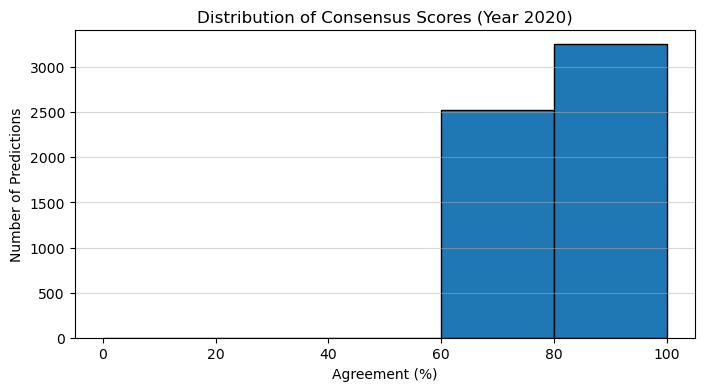

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

model_predictions = [
    lf_fine2020 ,
    lf_few2020 ,
    lf_zero2020 ,
    sb_fine2020 ,
    sb_zero2020
]

predictions = np.array(model_predictions)

consensus_scores = []
for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

consensus_percent = [score * 100 for score in consensus_scores]

print("=== Consensus Distribution ===")
print(f"Min Agreement: {np.min(consensus_percent):.0f}%")
print(f"Max Agreement: {np.max(consensus_percent):.0f}%")
print(f"Mean Agreement: {np.mean(consensus_percent):.0f}%")
print(f"Median Agreement: {np.median(consensus_percent):.0f}%")

plt.figure(figsize=(8, 4))
plt.hist(consensus_percent, bins=5, edgecolor='black', range=(0, 100))
plt.title("Distribution of Consensus Scores (Year 2020)")
plt.xlabel("Agreement (%)")
plt.ylabel("Number of Predictions")
plt.xticks(np.arange(0, 101, 20))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
d20=df_lf_fine_20[["Title", "Abstract","Paragraph"]].copy()
d20["Majority_Label"]=final_predictions

In [ ]:
d20.to_csv("2020_Majority_Labeled.csv")

## 2021

In [ ]:
import pandas as pd
df_lf_fine_21 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Fine-tuned_longformer/2021/Filtered_acl2021_labeled.csv",encoding="ISO-8859-1")
df_lf_few_21 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Few_shot_longformer/2021/Filtered_acl2021_fewshot.csv",encoding="ISO-8859-1")
df_lf_zero_21 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Zero_shot_longformer/2021/Filter_acl2021_zeroshot.csv",encoding="ISO-8859-1")
df_sb_fine_21 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Fine-tuned SciBert/2021/Filtered_acl2021_Sci_finetune.csv",encoding="ISO-8859-1")
df_sb_zero_21 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Zer-shot-SciBert/2021/Filtered_acl2021_scibert_zeroshot.csv",encoding="ISO-8859-1")


In [ ]:
lf_fine2021 = df_lf_fine_21["predicted_label_text"].tolist()
lf_few2021 = df_lf_few_21["predicted_label"].tolist()
lf_zero2021 = df_lf_zero_21["predicted_label"].tolist()
sb_fine2021 = df_sb_fine_21["predicted_label_text"].tolist()
sb_zero2021 = df_sb_zero_21["predicted_label"].tolist()

In [ ]:
import numpy as np
from collections import Counter

model_predictions = [
    lf_fine2021 ,
    lf_few2021 ,
    lf_zero2021 ,
    sb_fine2021 ,
    sb_zero2021
]

predictions = np.array(model_predictions)

final_predictions = []
consensus_scores = []

for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_predictions.append(majority_vote)

    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

print("Average Consensus:", f"{np.mean(consensus_scores):.0%}")

Average Consensus: 73%


=== Consensus Distribution ===
Min Agreement: 60%
Max Agreement: 100%
Mean Agreement: 73%
Median Agreement: 80%


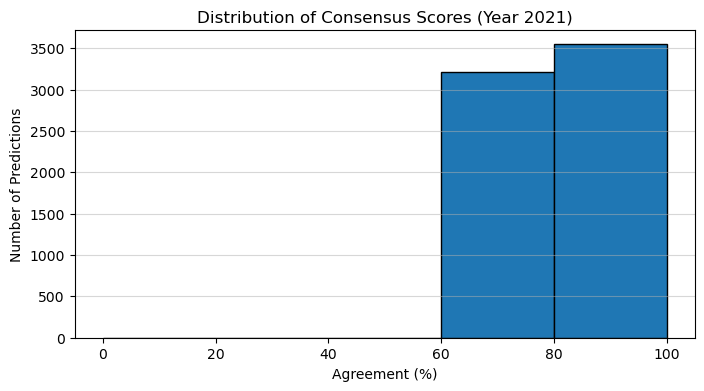

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

model_predictions = [
    lf_fine2021 ,
    lf_few2021 ,
    lf_zero2021 ,
    sb_fine2021 ,
    sb_zero2021
]

predictions = np.array(model_predictions)

consensus_scores = []
for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

consensus_percent = [score * 100 for score in consensus_scores]

print("=== Consensus Distribution ===")
print(f"Min Agreement: {np.min(consensus_percent):.0f}%")
print(f"Max Agreement: {np.max(consensus_percent):.0f}%")
print(f"Mean Agreement: {np.mean(consensus_percent):.0f}%")
print(f"Median Agreement: {np.median(consensus_percent):.0f}%")

plt.figure(figsize=(8, 4))
plt.hist(consensus_percent, bins=5, edgecolor='black', range=(0, 100))
plt.title("Distribution of Consensus Scores (Year 2021)")
plt.xlabel("Agreement (%)")
plt.ylabel("Number of Predictions")
plt.xticks(np.arange(0, 101, 20))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
d21=df_lf_fine_21[["Title", "Abstract","Paragraph"]].copy()
d21["Majority_Label"]=final_predictions

In [ ]:
d21.to_csv("2021_Majority_Labeled.csv")

## 2022

In [ ]:
import pandas as pd
df_lf_fine_22 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Fine-tuned_longformer/2022/Filtered_acl2022_labeled.csv",encoding="ISO-8859-1")
df_lf_few_22 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Few_shot_longformer/2022/Filtered_acl2022_fewshot.csv",encoding="ISO-8859-1")
df_lf_zero_22 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Zero_shot_longformer/2022/Filter_acl2022_zeroshot.csv",encoding="ISO-8859-1")
df_sb_fine_22 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Fine-tuned SciBert/2022/Filtered_acl2022_Sci_finetune.csv",encoding="ISO-8859-1")
df_sb_zero_22 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Zer-shot-SciBert/2022/Filtered_acl2022_scibert_zeroshot.csv",encoding="ISO-8859-1")


In [ ]:
lf_fine2022 = df_lf_fine_22["predicted_label_text"].tolist()
lf_few2022 = df_lf_few_22["predicted_label"].tolist()
lf_zero2022 = df_lf_zero_22["predicted_label"].tolist()
sb_fine2022 = df_sb_fine_22["predicted_label_text"].tolist()
sb_zero2022 = df_sb_zero_22["predicted_label"].tolist()

In [ ]:
import numpy as np
from collections import Counter

model_predictions = [
    lf_fine2022 ,
    lf_few2022 ,
    lf_zero2022 ,
    sb_fine2022 ,
    sb_zero2022
]
predictions = np.array(model_predictions)

# Majority voting
final_predictions = []
consensus_scores = []

for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_predictions.append(majority_vote)

    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

print("Average Consensus:", f"{np.mean(consensus_scores):.0%}")

Average Consensus: 74%


=== Consensus Distribution ===
Min Agreement: 60%
Max Agreement: 100%
Mean Agreement: 74%
Median Agreement: 80%


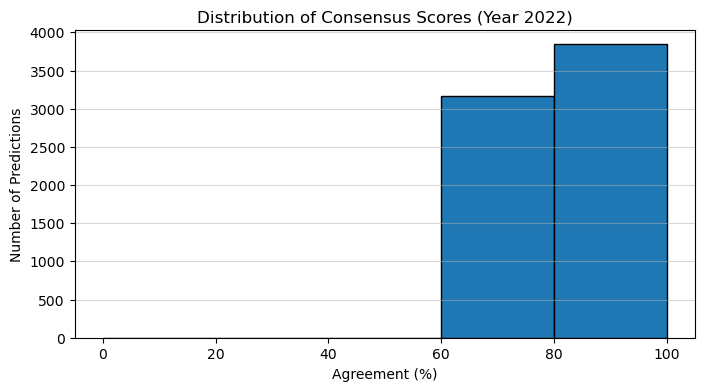

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

model_predictions = [
    lf_fine2022 ,
    lf_few2022 ,
    lf_zero2022 ,
    sb_fine2022 ,
    sb_zero2022
]

predictions = np.array(model_predictions)

consensus_scores = []
for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

consensus_percent = [score * 100 for score in consensus_scores]

print("=== Consensus Distribution ===")
print(f"Min Agreement: {np.min(consensus_percent):.0f}%")
print(f"Max Agreement: {np.max(consensus_percent):.0f}%")
print(f"Mean Agreement: {np.mean(consensus_percent):.0f}%")
print(f"Median Agreement: {np.median(consensus_percent):.0f}%")

plt.figure(figsize=(8, 4))
plt.hist(consensus_percent, bins=5, edgecolor='black', range=(0, 100))
plt.title("Distribution of Consensus Scores (Year 2022)")
plt.xlabel("Agreement (%)")
plt.ylabel("Number of Predictions")
plt.xticks(np.arange(0, 101, 20))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
d22=df_lf_fine_22[["Title", "Abstract","Paragraph"]].copy()
d22["Majority_Label"]=final_predictions

In [ ]:
d22.to_csv("2022_Majority_Labeled.csv")

## 2023

In [ ]:
import pandas as pd
df_lf_fine_23 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Fine-tuned_longformer/2023/Filtered_acl2023_labeled.csv",encoding="ISO-8859-1")
df_lf_few_23 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Few_shot_longformer/2023/Filtered_acl2023_fewshot.csv",encoding="ISO-8859-1")
df_lf_zero_23 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Zero_shot_longformer/2023/Filtered_acl2023_zeroshot.csv",encoding="ISO-8859-1")
df_sb_fine_23 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Fine-tuned SciBert/2023/Filtered_acl2023_Sci_finetune.csv",encoding="ISO-8859-1")
df_sb_zero_23 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Zer-shot-SciBert/2023/Filtered_acl2023_scibert_zeroshot.csv",encoding="ISO-8859-1")


In [ ]:
lf_fine2023 = df_lf_fine_23["predicted_label_text"].tolist()
lf_few2023 = df_lf_few_23["predicted_label"].tolist()
lf_zero2023 = df_lf_zero_23["predicted_label"].tolist()
sb_fine2023 = df_sb_fine_23["predicted_label_text"].tolist()
sb_zero2023 = df_sb_zero_23["predicted_label"].tolist()

In [ ]:
import numpy as np
from collections import Counter

model_predictions = [
    lf_fine2023 ,
    lf_few2023 ,
    lf_zero2023 ,
    sb_fine2023 ,
    sb_zero2023
]

predictions = np.array(model_predictions)

final_predictions = []
consensus_scores = []

for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_predictions.append(majority_vote)

    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)
print("Average Consensus:", f"{np.mean(consensus_scores):.0%}")

Average Consensus: 68%


=== Consensus Distribution ===
Min Agreement: 60%
Max Agreement: 100%
Mean Agreement: 68%
Median Agreement: 60%


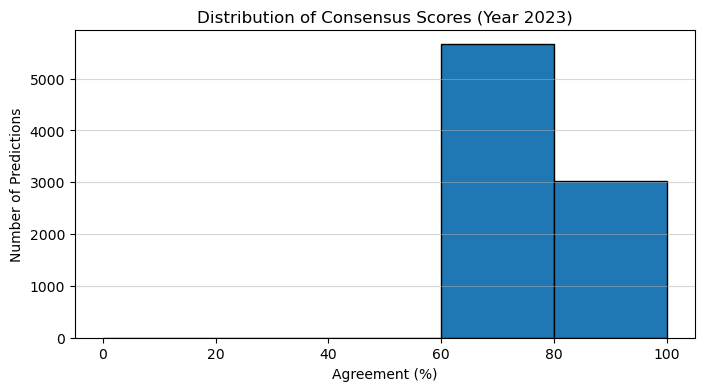

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

model_predictions = [
    lf_fine2023 ,
    lf_few2023 ,
    lf_zero2023 ,
    sb_fine2023 ,
    sb_zero2023
]

predictions = np.array(model_predictions)

consensus_scores = []
for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

consensus_percent = [score * 100 for score in consensus_scores]

print("=== Consensus Distribution ===")
print(f"Min Agreement: {np.min(consensus_percent):.0f}%")
print(f"Max Agreement: {np.max(consensus_percent):.0f}%")
print(f"Mean Agreement: {np.mean(consensus_percent):.0f}%")
print(f"Median Agreement: {np.median(consensus_percent):.0f}%")

plt.figure(figsize=(8, 4))
plt.hist(consensus_percent, bins=5, edgecolor='black', range=(0, 100))
plt.title("Distribution of Consensus Scores (Year 2023)")
plt.xlabel("Agreement (%)")
plt.ylabel("Number of Predictions")
plt.xticks(np.arange(0, 101, 20))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
d23=df_lf_fine_23[["Title", "Abstract","Paragraph"]].copy()
d23["Majority_Label"]=final_predictions

In [ ]:
d23.to_csv("2023_Majority_Labeled.csv")

## 2024

In [ ]:
import pandas as pd
df_lf_fine_24 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Fine-tuned_longformer/2024/Filtered_acl2024_labeled.csv",encoding="ISO-8859-1")
df_lf_few_24 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Few_shot_longformer/2024/Filtered_acl2024_fewshot.csv",encoding="ISO-8859-1")
df_lf_zero_24 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/Longformer/Zero_shot_longformer/2024/Filtered_acl2024_zeroshot.csv",encoding="ISO-8859-1")
df_sb_fine_24 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Fine-tuned SciBert/2024/Filtered_acl2024_Sci_finetune.csv",encoding="ISO-8859-1")
df_sb_zero_24 = pd.read_csv(r"/XXXX/ACL/CSVs/Labeled_by_Models/SciBert/Zer-shot-SciBert/2024/Filtered_acl2024_scibert_zeroshot.csv",encoding="ISO-8859-1")


In [ ]:
lf_fine2024 = df_lf_fine_24["predicted_label_text"].tolist()
lf_few2024 = df_lf_few_24["predicted_label"].tolist()
lf_zero2024 = df_lf_zero_24["predicted_label"].tolist()
sb_fine2024 = df_sb_fine_24["predicted_label_text"].tolist()
sb_zero2024 = df_sb_zero_24["predicted_label"].tolist()

In [ ]:
import numpy as np
from collections import Counter

model_predictions = [
    lf_fine2024 ,
    lf_few2024 ,
    lf_zero2024 ,
    sb_fine2024 ,
    sb_zero2024
]

predictions = np.array(model_predictions)

final_predictions = []
consensus_scores = []

for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_predictions.append(majority_vote)

    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

print("Average Consensus:", f"{np.mean(consensus_scores):.0%}")

Average Consensus: 67%


=== Consensus Distribution ===
Min Agreement: 60%
Max Agreement: 100%
Mean Agreement: 67%
Median Agreement: 60%


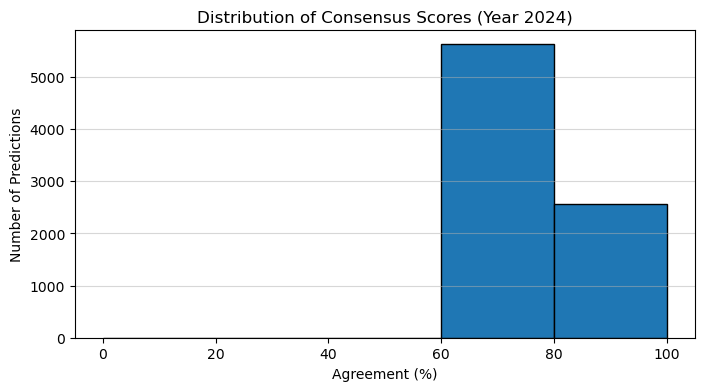

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

model_predictions = [
    lf_fine2024 ,
    lf_few2024 ,
    lf_zero2024 ,
    sb_fine2024 ,
    sb_zero2024
]

predictions = np.array(model_predictions)

consensus_scores = []
for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

consensus_percent = [score * 100 for score in consensus_scores]

print("=== Consensus Distribution ===")
print(f"Min Agreement: {np.min(consensus_percent):.0f}%")
print(f"Max Agreement: {np.max(consensus_percent):.0f}%")
print(f"Mean Agreement: {np.mean(consensus_percent):.0f}%")
print(f"Median Agreement: {np.median(consensus_percent):.0f}%")

plt.figure(figsize=(8, 4))
plt.hist(consensus_percent, bins=5, edgecolor='black', range=(0, 100))
plt.title("Distribution of Consensus Scores (Year 2024)")
plt.xlabel("Agreement (%)")
plt.ylabel("Number of Predictions")
plt.xticks(np.arange(0, 101, 20))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
d24=df_lf_fine_24[["Title", "Abstract","Paragraph"]].copy()
d24["Majority_Label"]=final_predictions

In [ ]:
d24.to_csv("2024_Majority_Labeled.csv")

## All Year

In [ ]:
lf_fine_all= lf_fine2020+lf_fine2021+lf_fine2022+lf_fine2023+lf_fine2024
lf_few_all= lf_few2020+lf_few2021+lf_few2022+lf_few2023+lf_few2024
lf_zero_all= lf_zero2020+lf_zero2021+lf_zero2022+lf_zero2023+lf_zero2024
sb_fine_all= sb_fine2020+sb_fine2021+sb_fine2022+sb_fine2023+sb_fine2024
sb_zero_all= sb_zero2020+sb_zero2021+sb_zero2022+sb_zero2023+sb_zero2024

=== Consensus Distribution ===
Min Agreement: 60%
Max Agreement: 100%
Mean Agreement: 71%
Median Agreement: 60%


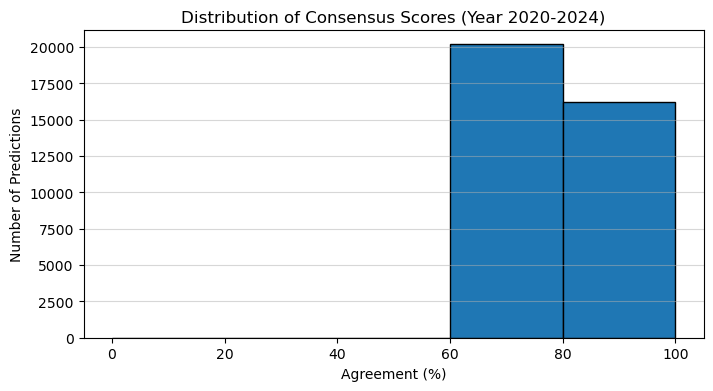

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

model_predictions = [
    lf_fine_all ,
    lf_few_all ,
    lf_zero_all ,
    sb_fine_all ,
    sb_zero_all
]

predictions = np.array(model_predictions)

consensus_scores = []
for i in range(predictions.shape[1]):
    votes = predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    agreement = np.mean(votes == majority_vote)
    consensus_scores.append(agreement)

consensus_percent = [score * 100 for score in consensus_scores]

print("=== Consensus Distribution ===")
print(f"Min Agreement: {np.min(consensus_percent):.0f}%")
print(f"Max Agreement: {np.max(consensus_percent):.0f}%")
print(f"Mean Agreement: {np.mean(consensus_percent):.0f}%")
print(f"Median Agreement: {np.median(consensus_percent):.0f}%")

plt.figure(figsize=(8, 4))
plt.hist(consensus_percent, bins=5, edgecolor='black', range=(0, 100))
plt.title("Distribution of Consensus Scores (Year 2020-2024)")
plt.xlabel("Agreement (%)")
plt.ylabel("Number of Predictions")
plt.xticks(np.arange(0, 101, 20))
plt.grid(axis='y', alpha=0.5)
plt.show()